In [1]:
import torch
import os
import sys
import scanpy as sc
import pandas as pd
import numpy as np
# runTangram
import tangram as tg

In [41]:
tg.__version__
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # 添加环境变量

In [5]:
adata = sc.read('./adata.addDEG.h5ad')
spatial_adata = sc.read('./adata_a2p2.telen.m500.log1p.leiden.deg.h5ad')

Only considering the two last: ['.deg', '.h5ad'].
Only considering the two last: ['.deg', '.h5ad'].


In [82]:
adata

AnnData object with n_obs × n_vars = 10927 × 1790
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'sparsity'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_ct', 'rank_genes_groups_leiden', 'rank_genes_groups_qijt', 'umap', 'cell type_colors', 'training_genes', 'overlap_genes'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

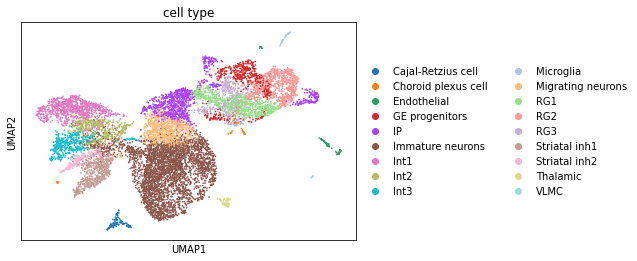

In [12]:
sc.pl.umap(adata,color="cell type")

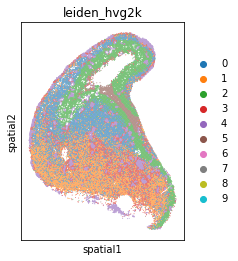

In [32]:
sc.pl.spatial(spatial_adata, color=["leiden_hvg2k"],library_id=None,spot_size=1)

In [47]:
def runTangram(sc_data,sp_data, marker=None,mode="cells",out="./result",key_deg="rank_genes_groups",
               use_raw_sc=None,use_raw_sp=None,cluster_label=None,top_n_markers=100):
    # Read in ad_sc & ad_sp
    warn("Read in ad_sc and ad_sp")
    ad_sc = sc_data
    ad_sp = sp_data

    if use_raw_sc:
        ad_sc = ad_sc.raw.to_adata().copy()
    if use_raw_sp:
        ad_sp = ad_sp.raw.to_adata().copy()

    # Get marker
    warn("Get marker")
    if marker is not None:
        marker = pd.read_csv(marker, header=None)
        marker = list(marker[0])
    else:
        marker = pd.DataFrame(ad_sc.uns[key_deg]['names']).head(top_n_markers)
        marker = np.array(marker).flatten().tolist()

    # Run pp_adatas
    warn("Run pp_adatas")
    tg.pp_adatas(adata_sc=ad_sc, adata_sp=ad_sp, genes=marker)
    if not ad_sc.uns['training_genes'] == ad_sp.uns['training_genes']:
        print("Training genes in ad_sc and ad_sp are not identical!")
        sys.exit(1)

    warn("Run tangram mapping")
    # Mapping
    
    with torch.cuda.device(0):
        if mode == 'cells':
            ad_map = tg.map_cells_to_space(
                adata_sc=ad_sc,
                adata_sp=ad_sp,
                device="cuda",
                mode=mode
            )
        else:
            ad_map = tg.map_cells_to_space(
                adata_sc=ad_sc,
                adata_sp=ad_sp,
                device="cuda",
                mode=mode,
                cluster_label=cluster_label
            )
    torch.cuda.empty_cache()
    
    ## Save
    warn("Save mapping result")
    ad_map.write(out+'.'+mode+'.h5ad')

In [48]:
def warn(message):
    sys.stderr.write(message + "\n")

In [459]:
if __name__ == "__main__":
    descrition = 'Perform tangram mapping.'
    runTangram(adata, spatial_adata,mode="clusters",cluster_label="cell type")

In [7]:
res_spatial_adata = sc.read('./result.clusters.h5ad')
res_spatial_adata
#res_spatial_adata.var.index.identical(spatial_adata.obs.index)

AnnData object with n_obs × n_vars = 18 × 26503
    obs: 'cell type', 'cluster_density'
    var: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'x', 'y', 'leiden_hvg2k', 'uniform_density', 'rna_count_based_density'
    uns: 'train_genes_df', 'training_history'

In [52]:
ad_ge = tg.project_genes(res_spatial_adata, adata,cluster_label='cell type')

In [8]:
tg.project_cell_annotations(res_spatial_adata, spatial_adata, annotation="cell type")

INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [10]:
spatial_adata.obsm['tangram_ct_pred']

,Immature neurons,IP,Int1,RG1,Migrating neurons,RG2,Striatal inh1,GE progenitors,Int3,Int2,RG3,Striatal inh2,Cajal-Retzius cell,Thalamic,Endothelial,Choroid plexus cell,Microglia,VLMC
spot|598|249,0.000030,0.000036,0.000018,4.672437e-05,2.791839e-05,0.000031,2.007531e-05,1.691835e-05,7.872888e-05,1.374024e-05,4.308745e-07,6.544615e-05,1.128259e-07,1.159201e-05,1.535513e-07,9.632503e-05,3.482055e-04,7.941459e-07
spot|598|250,0.000030,0.000040,0.000043,3.237566e-08,3.129580e-05,0.000033,3.425444e-05,2.498005e-05,7.890933e-06,9.237787e-07,1.339995e-04,5.783525e-08,2.254612e-04,4.261039e-05,5.032840e-05,5.523898e-08,8.473224e-08,9.740260e-05
spot|598|252,0.000030,0.000032,0.000043,4.172104e-05,3.097661e-05,0.000036,2.868577e-05,3.153205e-05,4.282830e-05,1.987177e-05,1.676354e-05,3.101182e-05,2.423545e-05,4.113398e-07,1.311785e-05,2.290755e-05,2.243688e-07,2.696542e-07
spot|599|245,0.000026,0.000023,0.000023,7.068567e-05,4.109077e-05,0.000017,2.765681e-05,8.986830e-05,1.232187e-04,1.053174e-06,5.277498e-08,2.287259e-07,1.716647e-05,3.120774e-08,5.388263e-05,9.390777e-08,1.044230e-07,2.342715e-04
spot|599|246,0.000034,0.000064,0.000036,3.636432e-05,1.517000e-07,0.000019,2.772953e-05,5.676187e-05,3.511469e-05,6.702373e-06,5.903178e-05,9.567205e-06,1.599611e-05,3.756988e-05,1.434367e-05,7.386255e-05,1.657194e-06,6.527935e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spot|839|334,0.000042,0.000053,0.000044,1.022173e-06,1.572084e-05,0.000047,2.058612e-05,2.318588e-07,8.733436e-08,3.168734e-05,8.257835e-05,4.811756e-05,1.927161e-07,3.213300e-05,1.143370e-07,3.193432e-07,2.542925e-05,1.638147e-03
spot|839|335,0.000035,0.000015,0.000022,3.995010e-05,4.941748e-05,0.000026,4.932613e-08,2.713737e-05,1.724681e-07,1.897888e-07,3.636347e-08,1.356167e-04,1.267337e-04,2.018928e-05,3.071917e-04,1.074057e-04,4.558512e-05,2.228878e-04
spot|840|328,0.000035,0.000027,0.000017,2.359118e-05,2.004764e-05,0.000016,2.024730e-05,7.473266e-05,4.403351e-05,2.181813e-08,8.427734e-05,6.462839e-08,4.916624e-08,2.842461e-04,1.165348e-04,2.978039e-06,8.919712e-08,7.185730e-08
spot|840|329,0.000036,0.000028,0.000020,3.715461e-05,2.823313e-05,0.000011,2.975914e-08,5.613413e-05,3.875082e-05,4.184242e-05,5.284015e-08,1.026375e-07,1.484642e-06,7.911089e-06,2.411669e-07,2.563340e-08,1.111621e-04,1.643998e-03


In [18]:
spatial_adata.obs["tangram_cell_type"] = spatial_adata.obsm["tangram_ct_pred"].idxmax(axis=1)
#sc.pl.spatial(spatial_adata, color=["tangram_ct_pred"],library_id=None,spot_size=1)

In [27]:
spatial_adata.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,x,y,leiden_hvg2k,tangram_cell_type
spot|598|249,284,5.652489,517.0,6.249975,37.330754,58.994197,83.752418,100.0,5.0,1.791759,0.967118,706.753061,-123.089346,2,Microglia
spot|598|250,304,5.720312,531.0,6.276643,37.099812,57.627119,80.414313,100.0,3.0,1.386294,0.564972,705.774913,-123.297257,3,Cajal-Retzius cell
spot|598|252,287,5.662960,517.0,6.249975,36.943907,58.413926,83.172147,100.0,8.0,2.197225,1.547389,703.818618,-123.713081,2,Int3
spot|599|245,332,5.808142,586.0,6.375025,34.129693,53.754266,77.474403,100.0,2.0,1.098612,0.341297,710.873563,-123.235847,4,VLMC
spot|599|246,318,5.765191,560.0,6.329721,36.428571,55.535714,78.928571,100.0,0.0,0.000000,0.000000,709.895416,-123.443758,2,Choroid plexus cell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spot|839|334,366,5.905362,634.0,6.453625,32.649842,50.630915,73.817035,100.0,16.0,2.833213,2.523659,673.717232,-376.495411,3,VLMC
spot|839|335,291,5.676754,562.0,6.333280,39.679715,60.498221,83.807829,100.0,7.0,2.079442,1.245552,672.739085,-376.703323,3,Endothelial
spot|840|328,286,5.659482,512.0,6.240276,40.234375,61.523438,83.203125,100.0,4.0,1.609438,0.781250,679.794030,-376.226089,4,Thalamic
spot|840|329,267,5.590987,501.0,6.218600,43.912176,64.471058,86.626747,100.0,4.0,1.609438,0.798403,678.815882,-376.434000,3,VLMC


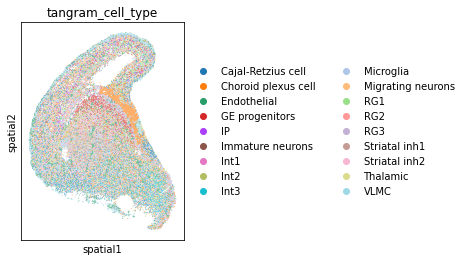

In [19]:
sc.pl.spatial(spatial_adata, color=["tangram_cell_type"],library_id=None,spot_size=1,save="spatial.pdf")

In [26]:
spatial_adata.write("./spatial_adata_annotated.h5ad")